In [1]:
import numpy as np
from TimeTagger import *
import matplotlib.pyplot as plt
from IPython.display import clear_output
import serial
import time

In [2]:
# Establish the serial connection
ser = serial.Serial('COM8', 9600)  # Replace 'COM3' with your Arduino's port
tagger = createTimeTagger()

print(ser.readline())
print(ser.readline())
print(ser.readline())

b'Demonstration of AccelStepper Library\r\n'
b"Send 'C' for printing the commands.\r\n"
b'Default speed: 400 steps/s, default acceleration: 800 steps/s^2.\r\n'


In [3]:
SPAD_CH = 1 # SPAD Channel
TRIG_CH = 3 # Trigger Channel

bin_width = 34 # in picoseconds, check once
nbins = 6e4  #with the knowledge that delay will be in ns, we can acquire 1us worth of temporal data, ie 1us/ 100ps = 1e4 bins. 
#1ns = 30cm spatially so even 1e3 bins should do

npulse = 100 #100 pulses at every position
trigfreq = 10*1e3 # trigger frequency, 10kHz (can't go higher as of now)

mini_step_size = 1/6400 #least count in cm/step
resolution = 0.01 #cm
step_size = resolution/mini_step_size

stepper_speed = step_size*trigfreq/npulse
# if I want 100 pulses to hit every point, them stepper motor must make 100 moves every second for given trigger frequency 
# stepper_speed = trigfreq//npulse #steps/second, resolution can be set as we want

#to move 2cm, stepper motor will need 2*6400 steps. at this speed, it will move for 2*64 = 128 seconds lmao
# works ig
direction = "left"


dist_in_cm = 2
nsteps = int(dist_in_cm/resolution)
t_acq = step_size/stepper_speed

In [4]:
print(f'SPAD_CH: {SPAD_CH}')
print(f'TRIG_CH: {TRIG_CH}')
print(f'bin_width: {bin_width} picoseconds')
print(f'nbins: {nbins}')
print(f'npulse: {npulse}')
print(f'trigfreq: {trigfreq} Hz')
print(f'stepper_speed: {stepper_speed} steps/second')
print(f'step_size: {step_size} cm/step')
print(f'dist_in_cm: {dist_in_cm} cm')
print(f'nsteps: {nsteps} steps')
print(f't_acq: {t_acq} seconds')

SPAD_CH: 1
TRIG_CH: 3
bin_width: 34 picoseconds
nbins: 60000.0
npulse: 100
trigfreq: 10000.0 Hz
stepper_speed: 6400.0 steps/second
step_size: 64.0 cm/step
dist_in_cm: 2 cm
nsteps: 200 steps
t_acq: 0.01 seconds


In [5]:

#Directions are given from the perspective facing HOLMARC sign in FSLab
def send_command(command):
    ser.write(command.encode())

def right_step(dist,speed):
    send_command(f'R{dist} {speed}')
    print(ser.readline())

def left_step(dist,speed):
    send_command(f'E{dist} {speed}')
    print(ser.readline())

def y_step(dist, speed):
    if direction.lower() == "left":
        left_step(dist,speed)
    elif direction.lower() == "right":
        right_step(dist,speed)
    else:
        exit()


def home_set():
    send_command('X')
    print(ser.readline())


def down_step(dist,speed):
    send_command(f'D{dist} {speed}')
    print(ser.readline())


def up_step(dist,speed):
    send_command(f'U{dist} {speed}')
    print(ser.readline())


def home_step():
    send_command('H')  
    print(ser.readline())
    print(ser.readline())
    print(ser.readline())

def getlocation():
    send_command('L')
    t =  int(ser.readline().split()[-1]), int(ser.readline().split()[-1])
    print(t)
    return t

def hist(t, bin_width, nbins):
    
    global SPAD_CH, TRIG_CH, tagger

    hist = Histogram(tagger, SPAD_CH, TRIG_CH, bin_width, nbins)
    hist.startFor(t*1e12) #60e12 #in ps
    while hist.isRunning():
        continue
    arr = np.array(hist.getData())
        # tt.getOverflowsAndClear()   
    clear_output(wait=True)     
    plt.plot(range(len(arr)),arr)
    plt.show()
    x =  arr.argmax()*bin_width

    return x

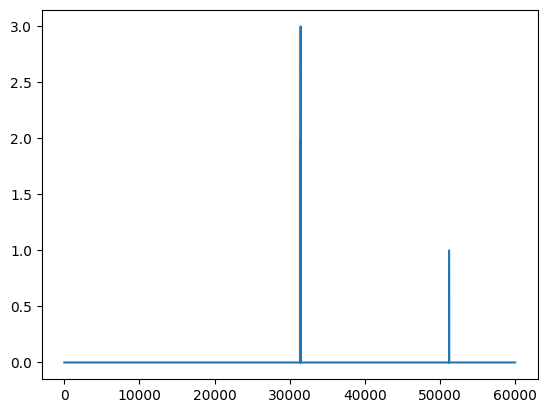

b'Negative direction for Y-axis.\r\n'
(0, -12747)
(0, -12788)
(0, -12800)
(0, -12800)


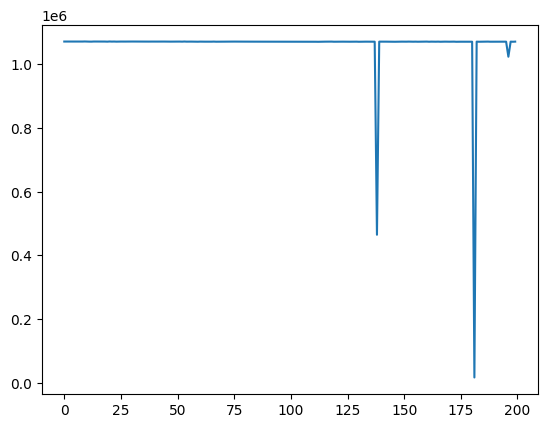

In [6]:
home_set()
# left_step(1600,100)
# print(getlocation())
# time.sleep(2)
# print(getlocation())


# left_step(nsteps*step_size,stepper_speed)

loc = getlocation()[1]

time_delay = []
for i in range(nsteps):
    
    time_delay.append(hist(t_acq,bin_width,nbins))
    if i%100==0:
        print(i)

    y_step(step_size,stepper_speed)
    while abs(getlocation()[1]-loc) < step_size:
        continue
    loc = getlocation()[1]
plt.plot(time_delay)
plt.show()
#home_step()


step_size2 = 100 #take 100 steps every turn for niter iterations #100/6400 ~ 
niter = nsteps/step_size2
#pseudo
for i in range(niter):
    #take a step right_step(step_size2, stepper_speed)
    # retrieve location
    # if location is what we expect
    # take and save histogram
    # repeat

In [7]:
home_step()

b'Homing X and Y axes.\r\n'
b'X-axis is at the home position.\r\n'
b'Y-axis is goimg to the home position.\r\n'


In [8]:
np.savetxt('C:/Users/krish/Desktop/9jan2024_2cm_0.01res_34ps.txt',time_delay)

In [9]:
#plt.plot(time_delay[0:50]+list(np.zeros(75)+1.06888e6)+time_delay[125:])

time_delay = np.array(time_delay)

time_delay = time_delay[time_delay>1.05e6]

plt.plot(time_delay)

np.savetxt('C:/Users/krish/Desktop/9jan2024_2cm_0.01res_34ps_cleaned.txt',time_delay)

In [ ]:
#what we can try: 

# keep moving it slowly but continuously

#for time in time_array:
# if time.time() > start_time + time:
# time_delay.append(hist(t_acq,bin_width,nbins)) 

#moving slowly: no more problem of effects from acceleration, deceleration

#some other tests: figure out how well actual speed matches to input speed.


#scan at resolution: 1 every 0.5 seconds, with speed being 64 steps/second -> resolution of 32/6400 * 1cm = very good

In [ ]:
home_set()

time_array = 

time_delay = []
for time in range(time_array):
    
    time_delay.append(hist(t_acq,bin_width,nbins))
    if i%100==0:
        print(i)


plt.plot(time_delay)
plt.show()
#home_step()
